In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Training
# Load the dataset
data = pd.read_csv("matched_data.csv")  # Replace with your actual file path

# Preprocess the data
class PoemDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)

        # Pad labels to match max_len
        label = torch.tensor(
            label + [0] * (self.max_len - len(label)), dtype=torch.long
        )

        return input_ids, attention_mask, label


# Prepare data
MAX_LEN = 128  # Adjust as needed
texts = data["Column1"].tolist()
labels = data["Column1_Tag"].apply(lambda x: [int(char) for char in str(x)]).tolist()

# Split data into train and test sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.1, random_state=42
)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("SIKU-BERT/sikubert")
sikubert = AutoModel.from_pretrained("SIKU-BERT/sikubert")

train_dataset = PoemDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = PoemDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Define the model
class WordSegmentationModel(nn.Module):
    def __init__(self, sikubert):
        super(WordSegmentationModel, self).__init__()
        self.sikubert = sikubert
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(sikubert.config.hidden_size, 2)  # Binary classification

    def forward(self, input_ids, attention_mask):
        outputs = self.sikubert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        return logits


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WordSegmentationModel(sikubert).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for input_ids, attention_mask, labels in tqdm(train_loader):
            input_ids, attention_mask, labels = (
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device),
            )
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs.view(-1, 2), labels.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader)}")

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for input_ids, attention_mask, labels in val_loader:
                input_ids, attention_mask, labels = (
                    input_ids.to(device),
                    attention_mask.to(device),
                    labels.to(device),
                )
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs.view(-1, 2), labels.view(-1))
                val_loss += loss.item()

        print(f"Epoch {epoch + 1}, Val Loss: {val_loss / len(val_loader)}")


# Train the model
# train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
# Save the model
# torch.save(model, "word_segmentation_model_full.pth")

In [3]:
# Load the saved model
model = torch.load("word_segmentation_model_full.pth")
model.eval()  # Set to evaluation mode
print("Model loaded successfully!")


C:\Users\linxi\AppData\Local\Temp\ipykernel_13016\3696415269.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("word_segmentation_model_full.pth")


Model loaded successfully!


In [4]:
# Test

# Define the testing function
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for input_ids, attention_mask, labels in tqdm(test_loader):
            input_ids, attention_mask, labels = (
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device),
            )

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=2)  # Get the class with the highest score

            # Flatten predictions and labels for evaluation
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    return all_preds, all_labels


# Prepare the test dataset and loader
test_texts = data["Column2"].tolist()  # Replace with actual test texts
test_labels = data["Column2_Tag"].apply(lambda x: [int(char) for char in str(x)]).tolist()

test_dataset = PoemDataset(test_texts, test_labels, tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=32)

# # Run the testing function
# preds, labels = test_model(model, test_loader)

# # Filter out padding tokens (assume label -1 is used for padding during training)
# valid_preds = [p for p, l in zip(preds, labels) if l != -1]
# valid_labels = [l for l in labels if l != -1]

# # Evaluate with classification metrics
# print(classification_report(valid_labels, valid_preds, target_names=["Continuation", "Beginning"]))


In [4]:
# Define the function to predict tags
def predict_tags_batch(texts, model, tokenizer, max_len=128, batch_size=32):
    """
    Predict 01 labels for multiple Chinese texts in batch mode.
    
    Args:
        texts (list): List of input Chinese texts.
        model: Trained word segmentation model.
        tokenizer: SikuBERT tokenizer.
        max_len (int): Maximum sequence length for padding/truncation.
        batch_size (int): Number of texts to process in one batch.
    
    Returns:
        list of list of int: Predicted tags (01 labels) for each text.
    """
    model.eval()
    
    # Tokenize all texts
    encodings = tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    
    input_ids = encodings["input_ids"]
    attention_mask = encodings["attention_mask"]
    
    # Split data into batches
    num_batches = (len(texts) + batch_size - 1) // batch_size
    predicted_tags = []

    with torch.no_grad():
        for i in range(num_batches):
            # Get batch data
            batch_input_ids = input_ids[i * batch_size : (i + 1) * batch_size].to(device)
            batch_attention_mask = attention_mask[i * batch_size : (i + 1) * batch_size].to(device)
            
            # Predict
            outputs = model(batch_input_ids, batch_attention_mask)
            batch_predictions = torch.argmax(outputs, dim=2).cpu().numpy()
            
            # Convert predictions to list of lists (remove padding)
            for j, prediction in enumerate(batch_predictions):
                text_length = len(texts[i * batch_size + j])
                pred = prediction[:text_length].tolist()

                if pred[0] == 0:
                    pred[0] = 1
                predicted_tags.append(pred)
                
    return predicted_tags


In [8]:
# Appllication of the word segmentation model and cosine similarity comparison 

# load the selected raw couplets texts
data = pd.read_csv('filtered_survey_results.csv')
text = data.columns[3:].to_list()

# Predict the word segmentation tags
upper_half_text = []
lower_half_text = []
for i,string in enumerate(text):
    if len(string.split('，')) == 2:
        upper_half_text.append(string.split('，')[0])
        lower_half_text.append(string.split('，')[1])
    else:
        upper_half_text.append(string.split(' ')[0])
        lower_half_text.append(string.split(' ')[1])
survey_df = pd.DataFrame({'Column1': upper_half_text, 
                          'Column2': lower_half_text})
upper_half = predict_tags_batch(upper_half_text, model, tokenizer, batch_size=32)
lower_half = predict_tags_batch(lower_half_text, model, tokenizer, batch_size=32)
survey_df['Column1_Tag'] = upper_half
survey_df['Column2_Tag'] = lower_half

# Compute cosine similarity
def cosine_similarity(row):
    array1 = np.array(row["Column1_Tag"])
    array2 = np.array(row["Column2_Tag"])
    return np.dot(array1, array2) / (np.linalg.norm(array1) * np.linalg.norm(array2))
survey_df["cosine_similarity"] = survey_df.apply(cosine_similarity, axis=1)

survey_df

,Column1,Column2,Column1_Tag,Column2_Tag,cosine_similarity
0,红梅映雪千家瑞,赤县迎春百业新,"[1, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 0, 1, 0, 1]",0.816497
1,花明柳媚春光好,大江南北庆丰收,"[1, 1, 1, 1, 1, 0, 1]","[1, 0, 0, 0, 1, 1, 0]",0.471405
2,水无两点不成冰,王不出头谁是主,"[1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 0, 1, 1, 1]",0.925820
3,庄生梦蝶知无我,晏子分桃为有他,"[1, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 1]",1.000000
4,秋风送爽花正艳,雨打屋檐人未归,"[1, 0, 1, 1, 1, 1, 1]","[1, 1, 1, 0, 1, 1, 1]",0.833333
5,黄河东去流不息,庭前落叶扫无痕,"[1, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 0, 1, 1, 1]",0.912871
6,浪遏飞舟留客住,风吹垂柳赋情来,"[1, 1, 1, 0, 1, 1, 1]","[1, 1, 1, 0, 1, 1, 1]",1.000000
7,黄莺日日盼新岁,绿柳枝枝辞旧年,"[1, 0, 1, 0, 1, 1, 0]","[1, 1, 1, 0, 1, 1, 0]",0.894427


Optimized weights: [0.39889944 0.14893276 0.20507788 0.24708993]
Minimized RMSE: 0.2841199363810805


,Word Seg,POS Tagging,Sem: Sentence,Sem: Character,Human Rating,weighted_ave*10
0,0.816497,0.990683,0.766967,0.752056,8.092715,8.191366
1,0.471405,0.771589,0.721520,0.663895,6.741722,6.470003
2,0.925820,0.611607,0.752221,0.618250,7.298013,7.128377
3,1.000000,0.989565,0.894446,0.731698,8.470199,8.751142
4,0.833333,0.665038,0.757544,0.661324,7.523179,7.189178
5,0.912871,0.770374,0.704952,0.617138,7.470199,7.347144
6,1.000000,0.937875,1.000000,0.701200,8.410596,8.680684
7,0.894427,0.979158,0.850157,0.758124,9.013245,8.508391


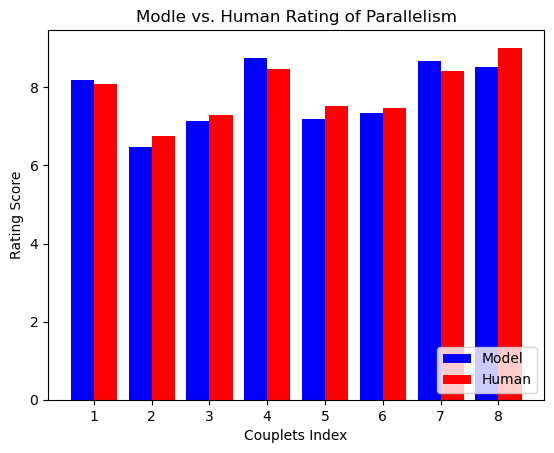

In [16]:
# Comparison of all models output and finding the optimized weights

from scipy.optimize import minimize
pos = pd.read_csv('pos_survey_ouput.csv')
sem = pd.read_csv('semantic.csv')
sem2 = pd.read_excel('semantic2.xlsx')
sim = pd.DataFrame({'Word Seg': survey_df['cosine_similarity'],
                    'POS Tagging': pos['Cosine_similarity'],
                    'Sem: Sentence': sem2['Similarity'],
                    'Sem: Character': sem['Similarity']})

w_initial = np.array([1/4, 1/4, 1/4, 1/4])
sim2 = sim[['Sem: Character','Sem: Sentence' ,'POS Tagging', 'Word Seg']]*10  # Placeholder matrix, replace with your actual data
human = np.array([8.092715, 6.741722, 7.298013, 8.470199, 7.523179, 7.470199, 8.410596, 9.013245])
sim['Human Rating'] = human
# RMSE calculation
def rmse(w):
    model = sim2 @ w  # Calculate model scores
    return np.sqrt(np.mean((human - model) ** 2))

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds: weights are between 0 and 1
bounds = [(0, 1) for _ in range(len(w_initial))]

# Minimize RMSE
result = minimize(rmse, w_initial, constraints=constraints, bounds=bounds)

# Optimized weights
w_optimized = result.x

print("Optimized weights:", w_optimized)
print("Minimized RMSE:", rmse(w_optimized))


sim['weighted_ave*10'] = sim2 @ w_optimized
display(sim)

bar_width = 0.4
x = np.arange(1,9)
plt.bar(x-bar_width/2, sim['weighted_ave*10'], width=bar_width, label='Model', color='b')
plt.bar(x+bar_width/2, sim['Human Rating'], width=bar_width, label='Human', color='r')
plt.title('Modle vs. Human Rating of Parallelism')
plt.xlabel('Couplets Index')
plt.ylabel('Rating Score')
plt.legend(loc='lower right')
